In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# preprocessing lib
from scipy.stats import shapiro, boxcox
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Classifiers Evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

### 📌Load Data

In [30]:
dataset = pd.read_csv('weather.csv')

In [31]:
dataset.head().T

,0,1,2,3,4
MinTemp,8.0,14.0,13.7,13.3,7.6
MaxTemp,24.3,26.9,23.4,15.5,16.1
Rainfall,0.0,3.6,3.6,39.8,2.8
Evaporation,3.4,4.4,5.8,7.2,5.6
Sunshine,6.3,9.7,3.3,9.1,10.6
WindGustDir,NW,ENE,NW,NW,SSE
WindGustSpeed,30.0,39.0,85.0,54.0,50.0
WindDir9am,SW,E,N,WNW,SSE
WindDir3pm,NW,W,NNE,W,ESE
WindSpeed9am,6.0,4.0,6.0,30.0,20.0


In [32]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        366 non-null    float64
 1   MaxTemp        366 non-null    float64
 2   Rainfall       366 non-null    float64
 3   Evaporation    366 non-null    float64
 4   Sunshine       363 non-null    float64
 5   WindGustDir    363 non-null    object 
 6   WindGustSpeed  364 non-null    float64
 7   WindDir9am     335 non-null    object 
 8   WindDir3pm     365 non-null    object 
 9   WindSpeed9am   359 non-null    float64
 10  WindSpeed3pm   366 non-null    int64  
 11  Humidity9am    366 non-null    int64  
 12  Humidity3pm    366 non-null    int64  
 13  Pressure9am    366 non-null    float64
 14  Pressure3pm    366 non-null    float64
 15  Cloud9am       366 non-null    int64  
 16  Cloud3pm       366 non-null    int64  
 17  Temp9am        366 non-null    float64
 18  Temp3pm   

### 📌Check Null?

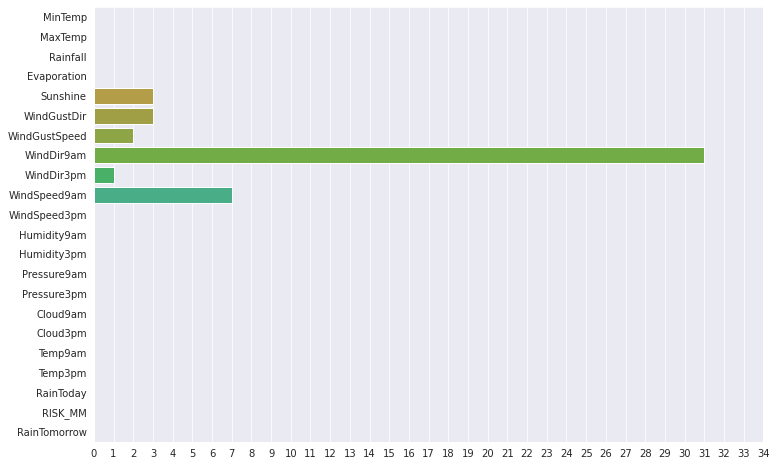

In [33]:
# detected null values by graph
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.barplot(dataset.isna().sum(), dataset.columns,)
plt.xticks(np.arange(35))
plt.show()

In [34]:
dataset.isna().sum()[dataset.isna().sum() >= 1].sort_values(ascending=False)\
        .reset_index()\
        .rename(columns={'index': 'columns name', 0: 'number of missing values'})

,columns name,number of missing values
0,WindDir9am,31
1,WindSpeed9am,7
2,Sunshine,3
3,WindGustDir,3
4,WindGustSpeed,2
5,WindDir3pm,1


In [35]:
# fill missing values having missing values
def fillnull(df, cols=None):
    if cols == None:
        df_num = df.select_dtypes(include=np.number)
        df_cat = df.select_dtypes(exclude=np.number)

        df_num = df_num.fillna(df_num.mean())
        df_cat = df_cat.fillna(df_cat.mode().iloc[0,0])
        return df_num.join(df_cat)
    else:
        df_num = df[cols].select_dtypes(include=np.number)
        df_cat = df[cols].select_dtypes(exclude=np.number)

        df_num = df_num.fillna(df_num.mean())
        df_cat = df_cat.fillna(df_cat.mode().iloc[0,0])
        return df_num.join(df_cat)[cols]

In [36]:
null_col = ['WindDir9am', 'WindSpeed9am', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir3pm']
dataset[null_col] = fillnull(dataset, null_col)

### 📌Check Redundant?

In [37]:
redd_list = []
for col in dataset.columns:
    if dataset[col].value_counts().max()/len(dataset) >= 0.80:
        redd_list.append(col)

dataset[redd_list].head()

,RainToday,RainTomorrow
0,No,Yes
1,Yes,Yes
2,Yes,Yes
3,Yes,Yes
4,Yes,No


In [38]:
encoding_y = LabelEncoder()
for col in redd_list:
    dataset[col] = encoding_y.fit_transform(dataset[col])

In [39]:
def count_values(df):
    for col in df.columns:
        print(df[col].value_counts())

In [40]:
# count_values(dataset)

### 📌 split category and numeric

In [41]:
binary_col = redd_list
num_col = dataset.select_dtypes(include=np.number).columns
cat_col = dataset.select_dtypes(exclude=np.number).columns 
len(binary_col), len(num_col), len(cat_col)

(2, 19, 3)

### 📌 Check Correlation?

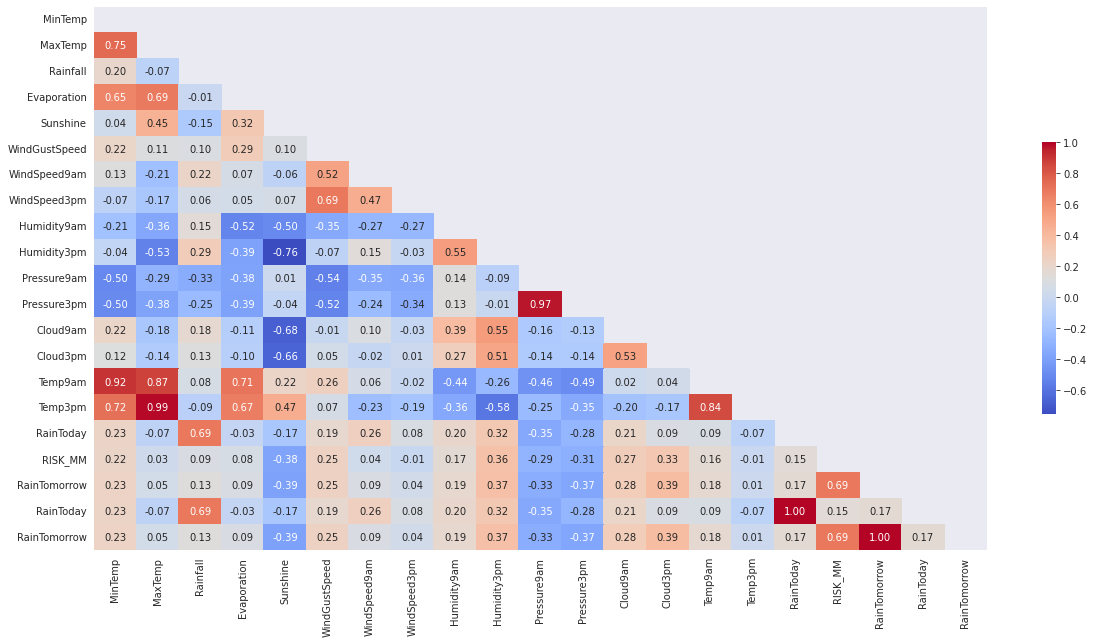

In [ ]:
plt.figure(figsize=(20, 10))
corr_mat = dataset[list(num_col)+list(binary_col)].corr()
mask =  np.triu(np.ones_like(corr_mat, dtype=bool))

sns.heatmap(corr_mat, mask=mask, annot=True, fmt = ".2f", cmap='coolwarm', cbar_kws={"shrink": .5});

In [55]:
def detected_highly_corr(df, target_name, threshold=0.75):
    # exclude categorical data, and target column
    num_cols_without_target = df.drop(columns=[target_name], axis=1).select_dtypes(include=np.number)
    # correlation matrix
    corr_matrix = num_cols_without_target.corr()
    # number of features
    n = len(corr_matrix)
    highly_corr_columns = []

    for row_index in range(n):
        for col_index in range(row_index+1, n):
            if abs(corr_matrix.values[row_index, col_index]) > threshold:
                row_corr_with_target = abs(np.corrcoef(df[target_name], df[num_cols_without_target.columns[row_index]])[0, 1])
                col_corr_with_target = abs(np.corrcoef(df[target_name], df[num_cols_without_target.columns[col_index]])[0, 1])
                    
                if row_corr_with_target > col_corr_with_target:
                    print('column has highly corr ', num_cols_without_target.columns[col_index])
                    highly_corr_columns.append(num_cols_without_target.columns[col_index])
                else:
                    print('column has highly corr', num_cols_without_target.columns[row_index])
                    highly_corr_columns.append(num_cols_without_target.columns[row_index])
    return highly_corr_columns

In [56]:
highly_corr_list = detected_highly_corr(dataset, 'RainTomorrow')

column has highly corr  MaxTemp
column has highly corr  Temp9am
column has highly corr MaxTemp
column has highly corr  Temp3pm
column has highly corr  Humidity3pm
column has highly corr Pressure9am
column has highly corr  Temp3pm


In [57]:
# drop highly correlated columns from train data and test parallel without cheats distribute
dataset.drop(highly_corr_list, axis=1, inplace=True)

### 📌 split X_train and X_VLD

In [58]:
X_train, X_vld = train_test_split(dataset, test_size=0.20, random_state=52)

In [59]:
binary_col = redd_list
num_col = dataset.select_dtypes(include=np.number).columns
cat_col = dataset.select_dtypes(exclude=np.number).columns
len(binary_col), len(num_col), len(cat_col)

(2, 14, 3)

### Draw Categories Columns

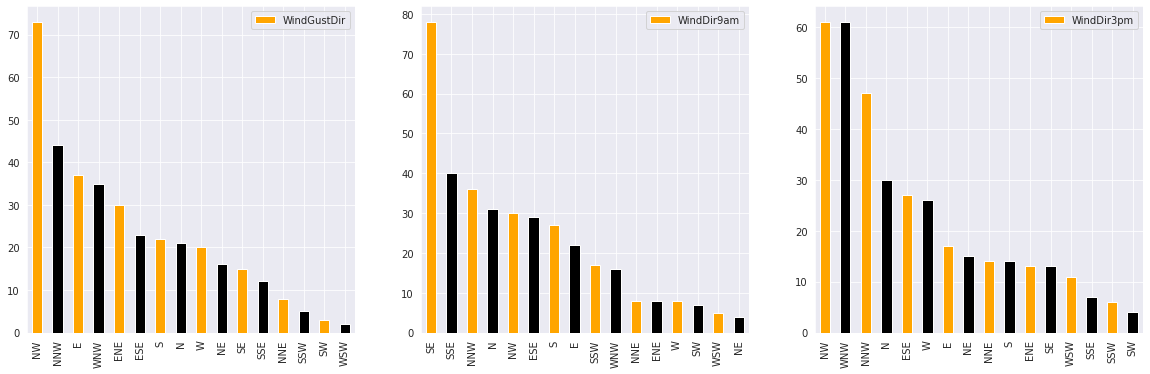

In [ ]:
fig, axs = plt.subplots(1, len(cat_col), figsize=(20, 6))
for col, ax in zip(cat_col, axs):
    dataset[col].value_counts().plot(kind="bar", ax=ax,  stacked=True, legend=True, color=['orange', 'black'])
plt.show()

### See Corr and dist between features..

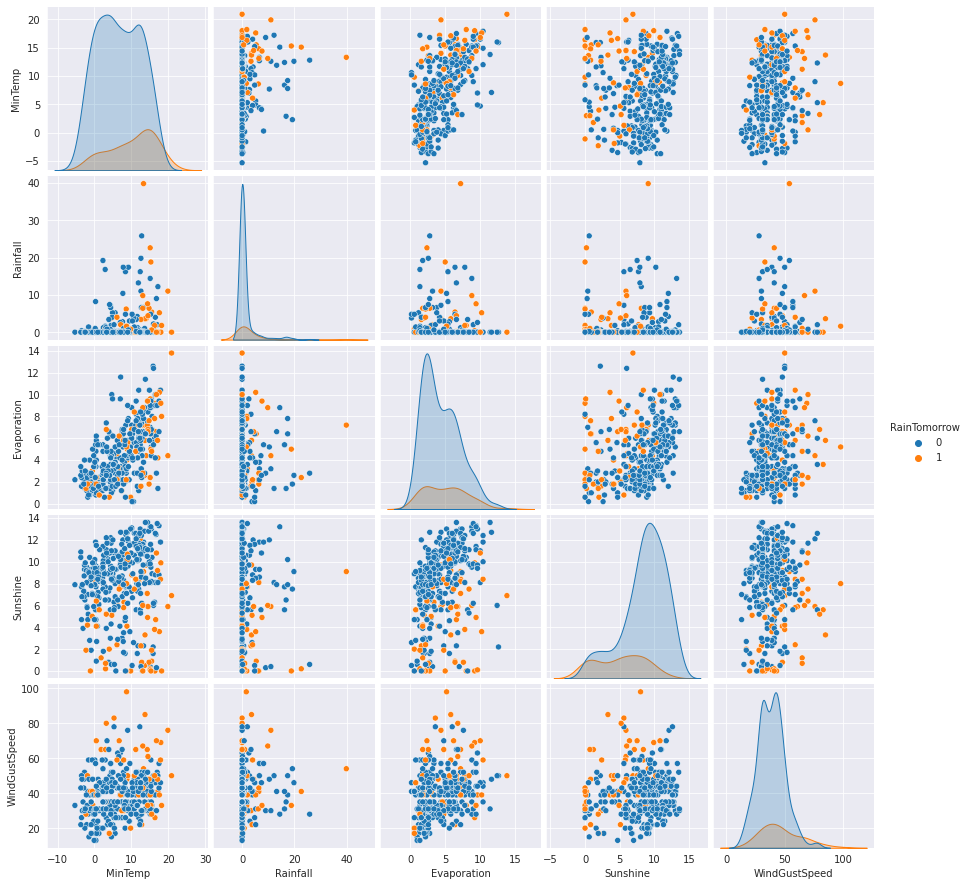

In [ ]:
sns.pairplot(data=dataset[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                           'WindGustSpeed', 'WindDir9am', 'RainTomorrow']], hue='RainTomorrow')

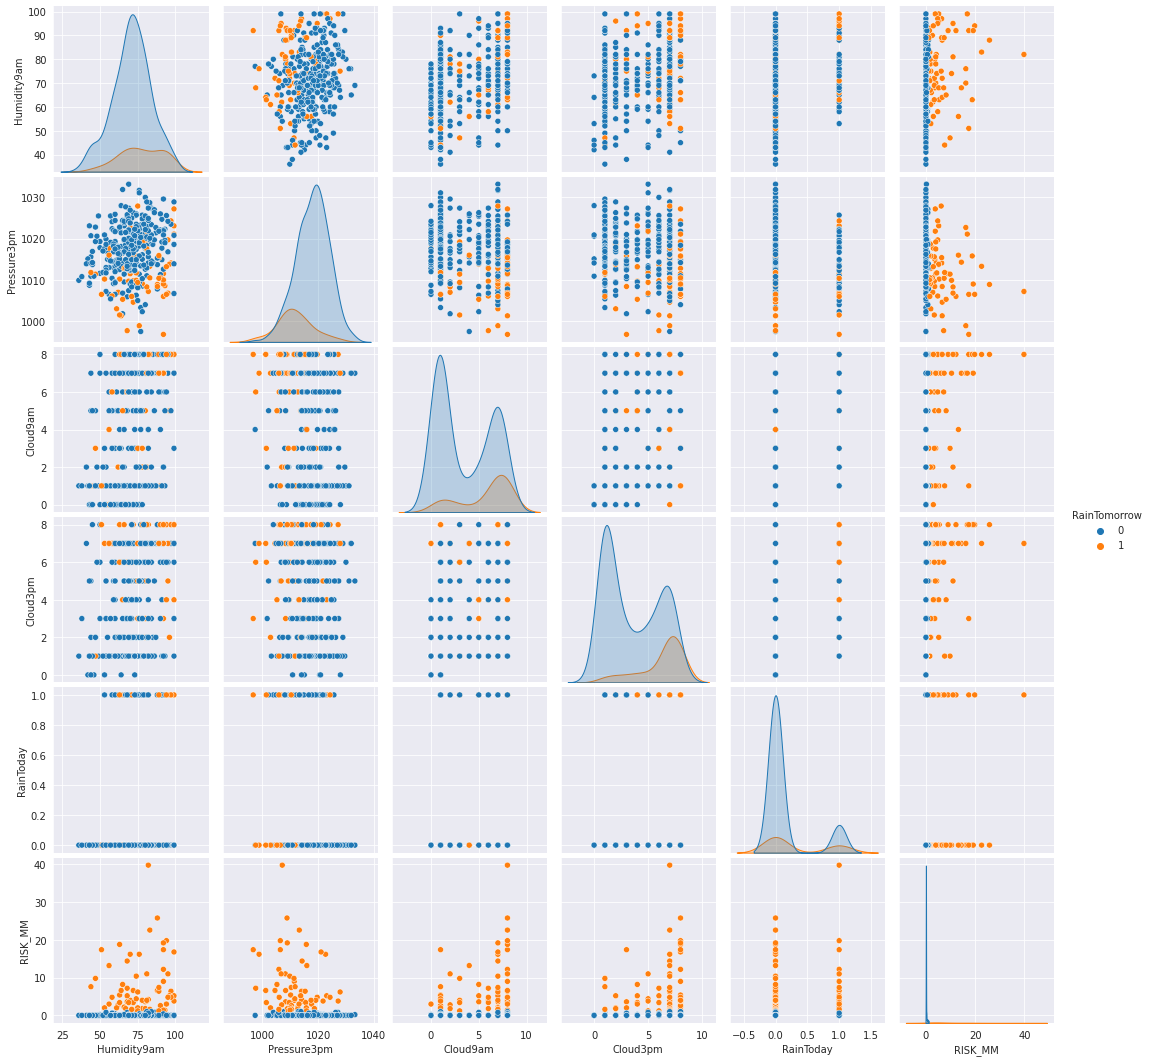

In [ ]:
sns.pairplot(data=dataset[['Humidity9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'RainToday', 'RISK_MM','WindDir3pm', 'RainTomorrow']], hue='RainTomorrow')

### 📌Check Outlier?

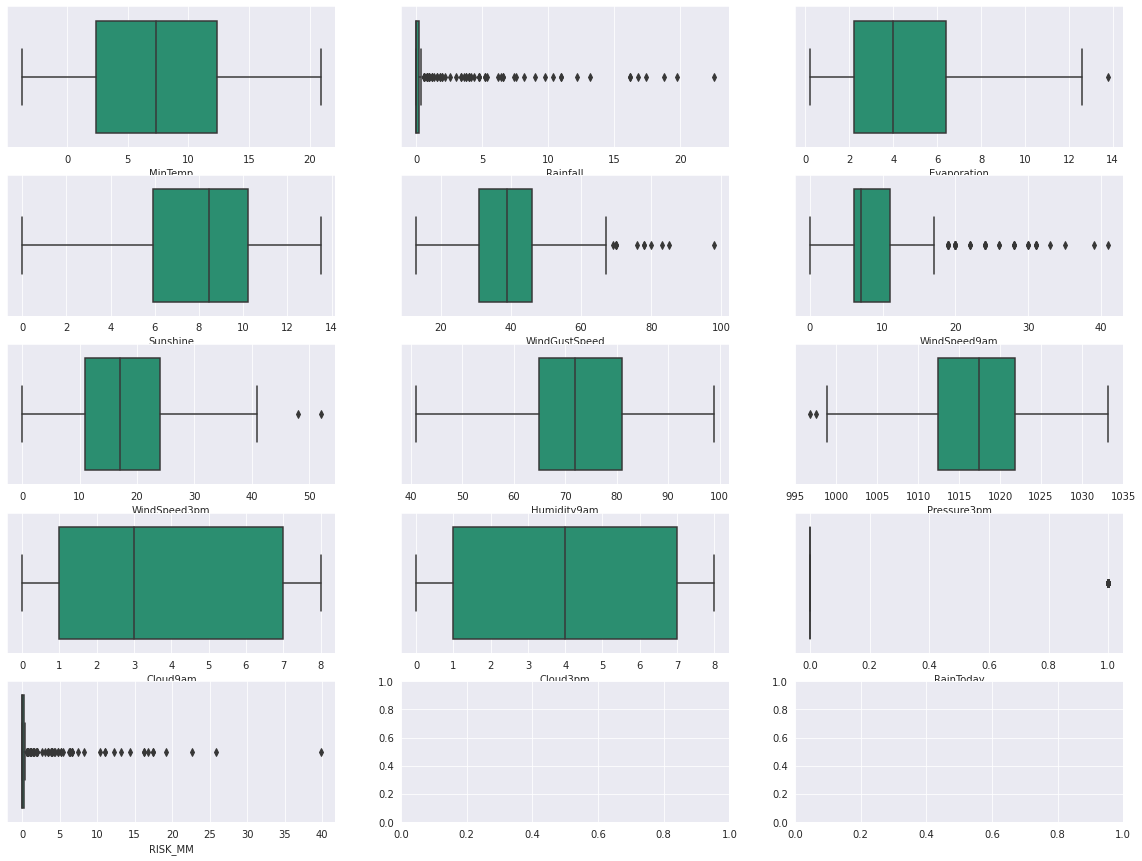

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 15))
for i, ax in zip(range(len(num_col[:-1])), axes.flat):
    sns.boxplot(X_train[num_col[i]], ax=ax, palette='Dark2')
plt.show()

In [ ]:
out_col = ['Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure3pm']

In [ ]:
# for col in out_col:
#     Q1, Q3 = np.quantile(X_train[col], [0.25, 0.75])
#     IQR = Q3 - Q1
#     lower_Q = Q1 - 1.5 * IQR
#     upper_Q = Q3 + 1.5 * IQR
#     X_train[col] = X_train[col].clip(lower=lower_Q, upper=upper_Q)

### 📌Distribution

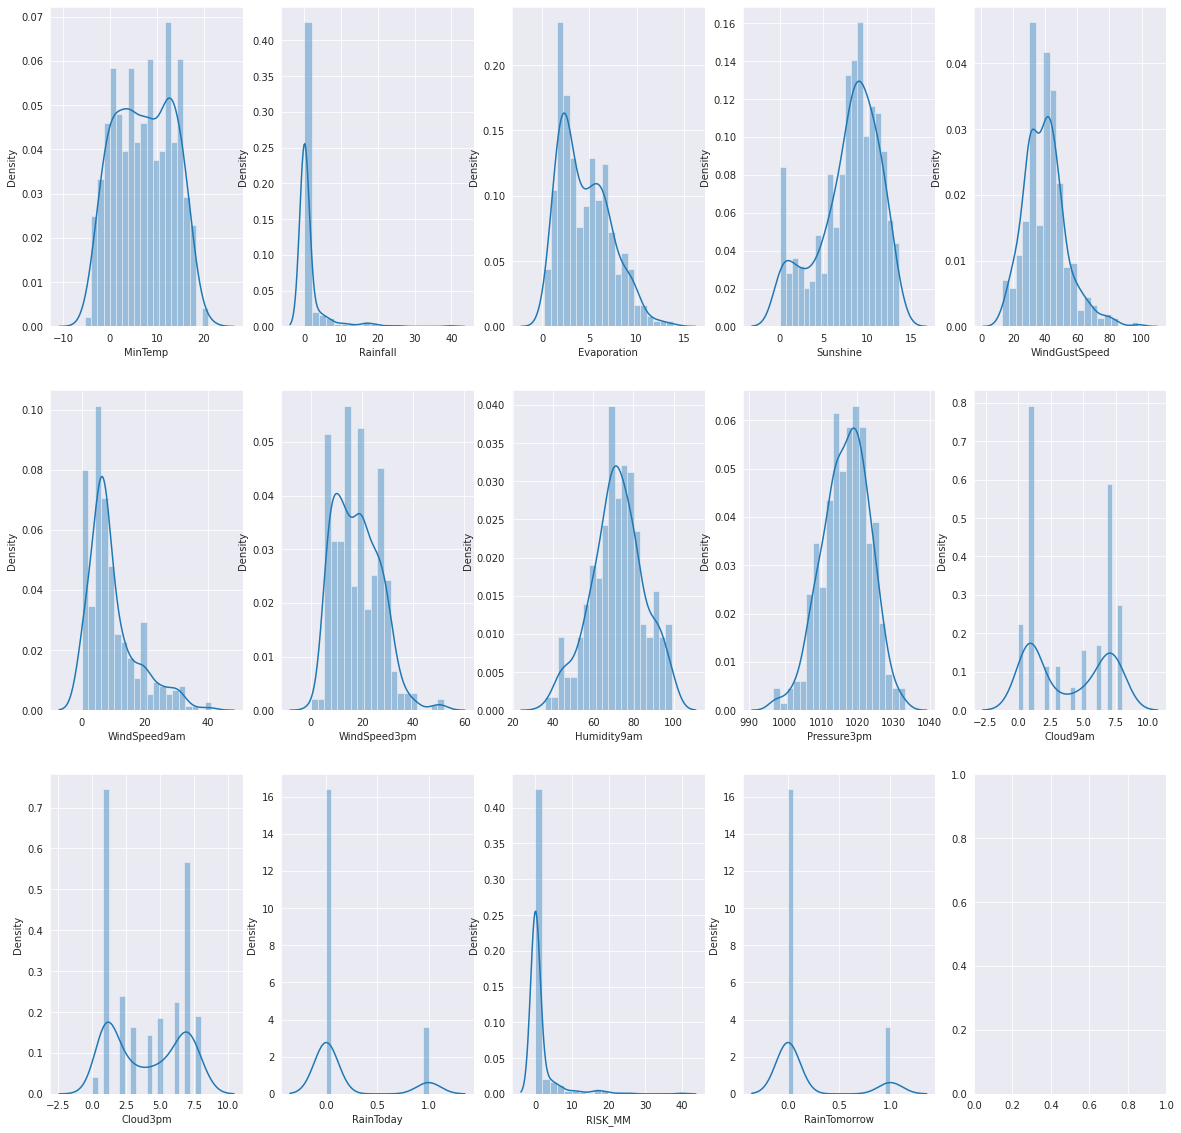

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(20, 20))

for i, ax in zip(range(len(num_col)), axes.flat):
    sns.distplot(dataset[num_col[i]], hist=True, bins=20, ax=ax)
plt.show()

In [20]:
X_train[num_col].describe().T[['mean', '50%', 'std',	'min', 'max']]

,mean,50%,std,min,max
MinTemp,7.279452,7.35,5.953380,-3.7,20.9
Rainfall,1.236986,0.00,3.455600,0.0,22.6
Evaporation,4.426027,4.00,2.640188,0.2,13.8
Sunshine,7.831946,8.45,3.460647,0.0,13.5
WindGustSpeed,39.920142,39.00,13.236831,13.0,98.0
WindSpeed9am,9.458599,7.00,7.814239,0.0,41.0
WindSpeed3pm,17.856164,17.00,8.899971,0.0,52.0
Humidity9am,72.558219,72.00,12.254743,41.0,99.0
Pressure3pm,1016.854110,1017.40,6.678355,996.8,1033.2
Cloud9am,3.886986,3.00,2.960955,0.0,8.0


### 📌 Skewness

In [21]:
X_train.skew().abs().sort_values(ascending=False)

RISK_MM          4.717129
Rainfall         3.733394
RainToday        1.754480
RainTomorrow     1.722661
WindSpeed9am     1.466606
WindGustSpeed    0.941885
Evaporation      0.722831
Sunshine         0.693817
WindSpeed3pm     0.544899
Pressure3pm      0.272602
Cloud3pm         0.101684
Cloud9am         0.094957
Humidity9am      0.069995
MinTemp          0.018674
dtype: float64

In [60]:
def skew(df, threshold=2):
    sk = df.skew().abs().sort_values(ascending=False).reset_index().rename({0:'value'}, axis=1)
    skew_list = list(sk[sk.value>=threshold]['index'])

    for col_name in skew_list:
        df[col_name] = np.log(1 + df[col_name])
        print('|+| Transformed: ', col_name)
    return df

X_train = skew(X_train)
X_vld = skew(X_vld)

|+| Transformed:  RISK_MM
|+| Transformed:  Rainfall
|+| Transformed:  Rainfall
|+| Transformed:  RISK_MM


### 📌Oversampling

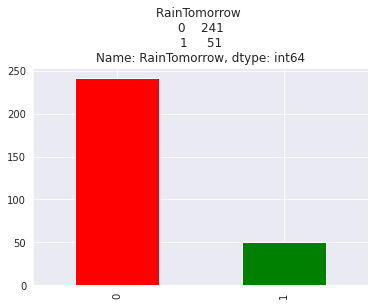

In [23]:
# do oversampling over only train data
X_train.RainTomorrow.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('RainTomorrow \n'+str(X_train.RainTomorrow.value_counts()))
plt.show()

In [64]:
from imblearn.over_sampling import SMOTENC

In [65]:
sm = SMOTENC(sampling_strategy='auto', random_state=42, categorical_features=[4,6,7])

over_w_train, over_y = sm.fit_resample(X_train.drop('RainTomorrow', axis=1), X_train['RainTomorrow'])
w_train = over_w_train.merge(over_y, left_index=True, right_index=True)
w_train.RainTomorrow.value_counts()

0    241
1    241
Name: RainTomorrow, dtype: int64

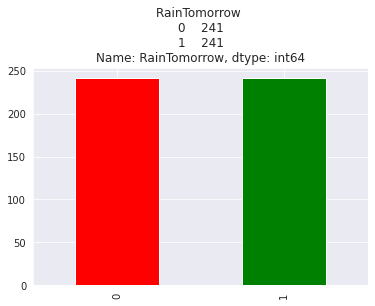

In [26]:
w_train.RainTomorrow.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('RainTomorrow \n'+str(w_train.RainTomorrow.value_counts()))
plt.show()

#### Split y target from X Features 

In [66]:
y_train = w_train['RainTomorrow']
y_vld = X_vld['RainTomorrow']

XX_train = w_train.iloc[:, :-1]
XX_vld = X_vld.iloc[:, :-1]

In [67]:
XX_train.shape, XX_vld.shape, y_train.shape, y_vld.shape

((482, 16), (74, 16), (482,), (74,))

### Do Scaling for Data (MINMAX)

In [68]:
minmax = MinMaxScaler()
XX_train[num_col[:-1]] = minmax.fit_transform(XX_train[num_col[:-1]])
XX_vld[num_col[:-1]] = minmax.transform(XX_vld[num_col[:-1]])

In [69]:
XX_train.shape, y_train.shape, XX_vld.shape, y_vld.shape

((482, 16), (482,), (74, 16), (74,))

### 📌Encoding Category

In [70]:
one_hot_enc_model = OneHotEncoder(handle_unknown='ignore', sparse=False)
nominal_train_data = one_hot_enc_model.fit_transform(XX_train[cat_col])

cols = one_hot_enc_model.get_feature_names_out(cat_col)
# train
df_train_data = pd.DataFrame(nominal_train_data, columns=cols, index=XX_train.index)    
nominal_train_df = pd.concat([df_train_data, XX_train], axis=1)
nominal_train_df.drop(cat_col, axis=1, inplace=True)

# test
nominal_test_data = one_hot_enc_model.transform(XX_vld[cat_col])
df_test_data = pd.DataFrame(nominal_test_data, columns=cols, index=XX_vld.index)
nominal_test_df = pd.concat([df_test_data, XX_vld], axis=1)
nominal_test_df.drop(cat_col, axis=1, inplace=True)


### 📌Collection 

In [71]:
nominal_train_df.shape, nominal_test_df.shape

((482, 61), (74, 61))

In [72]:
X_train = nominal_train_df
X_vld = nominal_test_df

### Molding

In [73]:
from sklearn.metrics import mean_squared_error as mse
def plot_confusion_matrix(y_true, y_pred, y_Label=None):
    column=[f'Predicted {label}' for label in y_Label]
    indices=[f'Actual {label}' for label in y_Label]
    table=pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)
    # YlOrRd, OrRd_r,Reds,YlGnBu,YlGnBu
    plt.title(f'confusion matrix, MSE={round(mse(y_true, y_pred),3)}')
    sns.heatmap(table,  fmt='d', annot = True, cmap='YlOrRd', )
    return plt.show()

def model_metrics(test_y, pred_y):
    model_acc = accuracy_score(test_y, pred_y)
    f_score = f1_score(test_y, pred_y, average='micro')
    classif = pd.DataFrame(classification_report(test_y, pred_y, output_dict=True)).T

    print('◤——————————————————————————————————————————————————————◥')
    print('      [ Accuracy: %.4f | f1 Score: %.4f ]*' % (model_acc, f_score))
    print(f'               [Classification Report]*: \n{classif}')
    print('◣——————————————————————————————————————————————————————◢')

In [ ]:
# from sklearn.model_selection import GridSearchCV

` every model fitting below i'm trying with various parameters values and finalize choices best param get best accuracy....`

#### 🔔 Logistic Regression

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 1.0000 | f1 Score: 1.0000 ]*
               [Classification Report]*: 
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     59.0
1                   1.0     1.0       1.0     15.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     74.0
weighted avg        1.0     1.0       1.0     74.0
◣——————————————————————————————————————————————————————◢


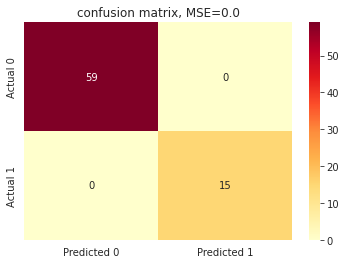

In [74]:
log = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=53)
log.fit(X_train, y_train)
y_pred = log.predict(X_vld)

model_metrics(y_vld, y_pred)
plot_confusion_matrix(y_vld, y_pred, y_Label=[0, 1])

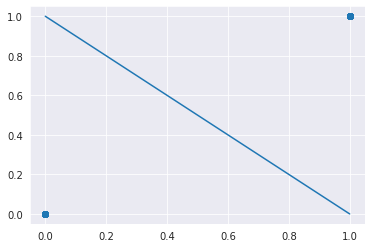

In [35]:
# plt.scatter(y_pred, y_vld)
# plt.plot([0,1],[1,0])

In [ ]:
y_pred_proba = log.predict_proba(X_vld)[::,1]
fpr, tpr, thresholds = roc_curve(y_vld, y_pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.8348397855162185


#### 🔔 Decision Tree

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 1.0000 | f1 Score: 1.0000 ]*
               [Classification Report]*: 
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     59.0
1                   1.0     1.0       1.0     15.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     74.0
weighted avg        1.0     1.0       1.0     74.0
◣——————————————————————————————————————————————————————◢


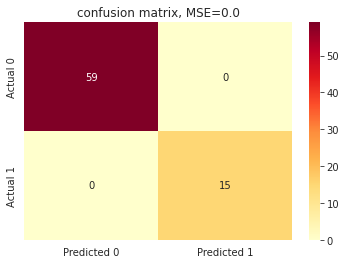

In [44]:
# 7
tree = DecisionTreeClassifier(max_depth=6, criterion="gini", class_weight='balanced', random_state=43, max_leaf_nodes=4, min_samples_split=5, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred=tree.predict(X_vld)
model_metrics(y_vld, y_pred)
plot_confusion_matrix(y_vld, y_pred, y_Label=[0, 1])

#### 🔔 Knirest k-nearest neighbors(KNN)

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 0.8649 | f1 Score: 0.8649 ]*
               [Classification Report]*: 
              precision    recall  f1-score    support
0              0.876923  0.966102  0.919355  59.000000
1              0.777778  0.466667  0.583333  15.000000
accuracy       0.864865  0.864865  0.864865   0.864865
macro avg      0.827350  0.716384  0.751344  74.000000
weighted avg   0.856826  0.864865  0.851242  74.000000
◣——————————————————————————————————————————————————————◢


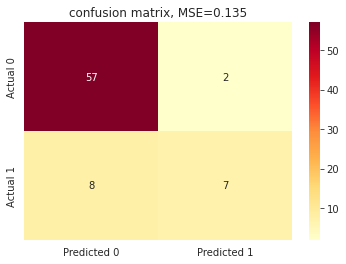

In [ ]:
knn = KNeighborsClassifier(n_neighbors=6, weights='distance', metric='minkowski', p=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_vld)

model_metrics(y_vld, y_pred)
plot_confusion_matrix(y_vld, y_pred, y_Label=[0, 1])

#### 🔔 SVM

##### Kernal linear

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 0.9865 | f1 Score: 0.9865 ]*
               [Classification Report]*: 
              precision    recall  f1-score    support
0              1.000000  0.983051  0.991453  59.000000
1              0.937500  1.000000  0.967742  15.000000
accuracy       0.986486  0.986486  0.986486   0.986486
macro avg      0.968750  0.991525  0.979597  74.000000
weighted avg   0.987331  0.986486  0.986647  74.000000
◣——————————————————————————————————————————————————————◢


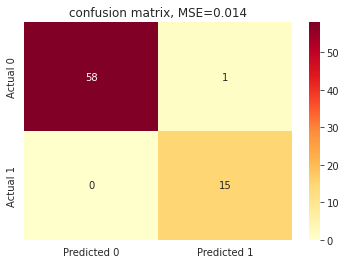

In [ ]:
svm = SVC(kernel='linear', C=18, class_weight='balanced', random_state=52)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_vld)

model_metrics(y_vld, y_pred)
plot_confusion_matrix(y_vld, y_pred, y_Label=[0, 1])

##### Kernal RBF

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 0.9595 | f1 Score: 0.9595 ]*
               [Classification Report]*: 
              precision    recall  f1-score    support
0              0.951613  1.000000  0.975207  59.000000
1              1.000000  0.800000  0.888889  15.000000
accuracy       0.959459  0.959459  0.959459   0.959459
macro avg      0.975806  0.900000  0.932048  74.000000
weighted avg   0.961421  0.959459  0.957710  74.000000
◣——————————————————————————————————————————————————————◢


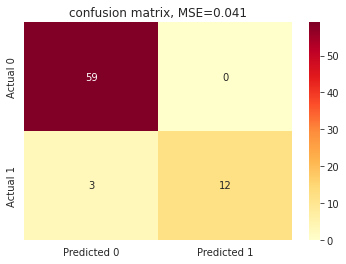

In [ ]:
svm = SVC(kernel='rbf', C=32, gamma=0.01, class_weight='balanced', random_state=53)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_vld)
model_metrics(y_vld, y_pred)
plot_confusion_matrix(y_vld, y_pred, y_Label=[0, 1])

##### Kernal Poly

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 0.9595 | f1 Score: 0.9595 ]*
               [Classification Report]*: 
              precision    recall  f1-score    support
0              0.951613  1.000000  0.975207  59.000000
1              1.000000  0.800000  0.888889  15.000000
accuracy       0.959459  0.959459  0.959459   0.959459
macro avg      0.975806  0.900000  0.932048  74.000000
weighted avg   0.961421  0.959459  0.957710  74.000000
◣——————————————————————————————————————————————————————◢


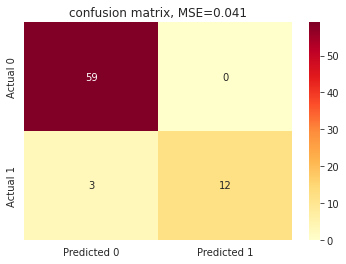

In [ ]:
svm = SVC(kernel='poly', degree=2, C=32, gamma=0.4, class_weight='balanced', random_state=43)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_vld)

model_metrics(y_vld, y_pred)
plot_confusion_matrix(y_vld, y_pred, y_Label=[0, 1])

### Best Model
#### data is separable so can classify by use linear models
<p style='color:blue;'>
Logistic Regression and Decision Tree</p>

<p> Accuracy: 1.0   |   Precision: 1.0   |  Recall: 1.0   |   F1: 1.0 </p>


<hr>

### $$ From ~Skratch ~Implementation $$
<hr>

In [130]:
Xt = X_train.values
Xv = X_vld.values
yt = y_train.values.reshape(-1, 1)
yv = y_vld.values.reshape(-1, 1)
Xt.shape, yt.shape, Xv.shape, yv.shape

((482, 61), (482, 1), (74, 61), (74, 1))

#### 📝Logistic Regression

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_fit(X, y, alpha=0.001, bias=True, max_iter=100):
    m, n= X.shape;  theta = np.zeros((n, 1))
    if bias:
        X = np.concatenate((np.ones((m, 1)), X), axis=1)
        theta = np.zeros((n+1, 1))
        m, n= X.shape
        
    for _ in range(max_iter):
        zz = np.dot(X, theta)
        theta = theta - alpha * np.dot(X.T, (sigmoid(zz) - y.reshape(-1, 1)))
    return theta


def logistic_predict(X, theta, bias=True, threshold = 0.5):
    m, n= X.shape
    if bias:
        X = np.concatenate((np.ones((m, 1)), X), axis=1)
        m, n= X.shape
    preds = [1 if i > threshold else 0 for i in sigmoid(np.dot(X, theta))]
    return preds

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 0.9595 | f1 Score: 0.9595 ]*
               [Classification Report]*: 
              precision    recall  f1-score    support
0              0.951613  1.000000  0.975207  59.000000
1              1.000000  0.800000  0.888889  15.000000
accuracy       0.959459  0.959459  0.959459   0.959459
macro avg      0.975806  0.900000  0.932048  74.000000
weighted avg   0.961421  0.959459  0.957710  74.000000
◣——————————————————————————————————————————————————————◢


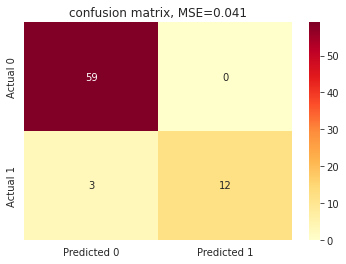

In [ ]:
w = logistic_fit(Xt, yt, alpha=0.02, bias=True, max_iter=2000)
pre = logistic_predict(X_vld.values, w, threshold=0.84)
model_metrics(y_vld, pre)
plot_confusion_matrix(y_vld, pre, y_Label=[0, 1])

#### 📝KNN 

In [ ]:
''' 
First, we calculate the distances.
Then we calculate the neighbors.
Finally, we make the prediction.
'''

' \nFirst, we calculate the distances.\nThen we calculate the neighbors.\nFinally, we make the prediction.\n'

In [ ]:
def euclidean_dis(row1, row2):
    return np.sqrt(np.sum((row1 - row2)**2))

def predict(X_train, y_train, X_test, k_neighbors=3):
        m = X_train.shape[0]
        n = X_test.shape[0]

        y_pred = []

        for i in range(n):  # for every sample in X_test
            distance = []  # To store the distances

            for j in range(m):  # for every sample in X_train
              d = euclidean_dis(X_test[i,:], X_train[j,:]) # Euclidean distance
              distance.append((d, y_train[j]))    

            distance = sorted(distance)

            # Getting k-nearest neighbors
            neighbors = []
            for item in range(k_neighbors):
                neighbors.append(distance[item][1])  # K-nearest neighbors

            y_pred.append(stats.mode(neighbors)[0][0])
        return np.array(y_pred)

In [ ]:
knn_ypre = predict(X_train=Xt, y_train=yt, X_test=Xv, k_neighbors=6)

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 0.8649 | f1 Score: 0.8649 ]*
               [Classification Report]*: 
              precision    recall  f1-score    support
0              0.888889  0.949153  0.918033  59.000000
1              0.727273  0.533333  0.615385  15.000000
accuracy       0.864865  0.864865  0.864865   0.864865
macro avg      0.808081  0.741243  0.766709  74.000000
weighted avg   0.856129  0.864865  0.856685  74.000000
◣——————————————————————————————————————————————————————◢


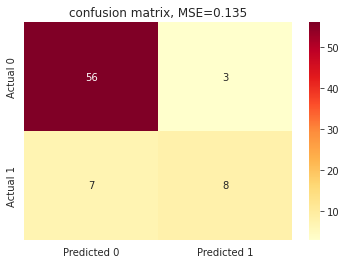

In [ ]:
model_metrics(yv ,knn_ypre);
plot_confusion_matrix(yv ,knn_ypre, [0, 1]);

#### 📝 Decision Tree

In [140]:
# calc entropy
def compute_entropy(samples):
    if len(samples) < 2:
        return 0
    freq = np.array(samples.value_counts(normalize=True))
    return -np.sum(freq * np.log2(freq + 1e-8))

# calc gain
def info_gain(X, col, y):
    values = X[col].value_counts(normalize=True)
    split_ent = 0

    for value, count in values.iteritems():
        idx = X[col] == value
        sub_ent = compute_entropy(y[idx])
        split_ent += count * sub_ent
    
    return compute_entropy(y) - split_ent

In [208]:
class TreeNode:
    def __init__(self, node='', min_sample=1, default_decision=None):
        self.children = {} 
        self.decision = None 
        self.split_feat = None
        self.min_sample = min_sample
        self.name = node
        self.default_decision = default_decision
        

    # predict function
    def calcu_predict(self, data):
        if self.decision is not None:
            return self.decision
        else:
            attr_val = data[self.split_feat]
            if self.children.get(attr_val) is None:
                return self.decision

            child = self.children[attr_val]
            return child.calcu_predict(data)

    # fit data to model
    def fit(self, data, target):
        if self.default_decision is None:
            self.default_decision = target.mode()[0]

        if len(data) < self.min_sample:
            if len(data) == 0:
                self.decision = self.default_decision
            else:
                self.decision = target.mode()[0]
            return 

        else:
            unique_values = target.unique()
            if len(unique_values) == 1:
                self.decision = unique_values[0]
                return
            else:
                # select split feature
                info_gain_max = 0
                for attr in data.keys(): # examine each attribute
                    attr_ig = info_gain(data, attr, target)
                    if attr_ig > info_gain_max:
                        info_gain_max = attr_ig
                        self.split_feat = attr

                self.children = {}
                for value in data[self.split_feat].unique():
                    idx = data[self.split_feat] == value
                    self.children[value] = TreeNode(node=self.name + ":" + self.split_feat + "==" + str(value),
                                                    min_sample=self.min_sample,
                                                    default_decision=self.default_decision)
                    self.children[value].fit(data[idx], target[idx])

    def predict(self, X, y):
      prediction = np.zeros_like(y).reshape(-1, 1)
      for i, (_, ct) in enumerate(X.iterrows()):
          prediction[i,:] = self.calcu_predict(ct)
      return prediction


In [ ]:
# clf = TreeNode(min_sample=12)
# clf.fit(X_train, y_train)
# model_metrics(y_train, clf.predict(X_train, y_train))

In [212]:
clf = TreeNode(min_sample=12)
clf.fit(X_vld, y_vld)
model_metrics(y_vld, clf.predict(X_vld, y_vld))

◤——————————————————————————————————————————————————————◥
      [ Accuracy: 1.0000 | f1 Score: 1.0000 ]*
               [Classification Report]*: 
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     59.0
1                   1.0     1.0       1.0     15.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     74.0
weighted avg        1.0     1.0       1.0     74.0
◣——————————————————————————————————————————————————————◢


#### 📝Support Vector Classification SVC

In [ ]:
import cvxopt
# import plotting
# import datageneration
import random as rnd
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

In [ ]:
cvxopt_solvers.options['show_progress'] = False

In [ ]:
#Initializing values and computing H. Note the 1. to force to float type
m,n = Xt.shape
y = yt * 1.
X_dash = yt * Xt
H = np.dot(X_dash , X_dash.T) * 1.0

#Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(-np.eye(m))
h = cvxopt_matrix(np.zeros(m))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])


#w parameter in vectorized form
w = ((yt * alphas).T .dot(Xt)).reshape(-1,1)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b
b = np.mean(yt[S] - np.dot(Xt[S], w))

#Display results
# print('Alphas = ',alphas[alphas > 1e-4])
# print('w = ', w.flatten())
# print('b = ', b)

In [ ]:
# predicting the y hat from our implementation for the train data
svm_preds_from_scratch = ((Xt.dot(w) + b >= 0)).astype(int)
sum(svm_preds_from_scratch.flatten() == yt.flatten())/len(yt)

0.6721991701244814